2025-07-20 08:41:04.431778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753000864.629236      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753000864.689647      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


I0000 00:00:1753000887.322887      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64


I0000 00:00:1753000905.313286      73 service.cc:148] XLA service 0x7be03c04c9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753000905.314290      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753000906.852813      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/163 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.3203 - loss: 0.8740  

I0000 00:00:1753000910.141523      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 622ms/step - accuracy: 0.6556 - loss: 0.6897 - val_accuracy: 0.7580 - val_loss: 0.4718 - learning_rate: 1.0000e-04
Epoch 2/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 316ms/step - accuracy: 0.9069 - loss: 0.2809 - val_accuracy: 0.7708 - val_loss: 0.4379 - learning_rate: 1.0000e-04
Epoch 3/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.9401 - loss: 0.1926 - val_accuracy: 0.7756 - val_loss: 0.4361 - learning_rate: 1.0000e-04
Epoch 4/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.9517 - loss: 0.1550 - val_accuracy: 0.7837 - val_loss: 0.4347 - learning_rate: 1.0000e-04
Epoch 5/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 315ms/step - accuracy: 0.9541 - loss: 0.1390 - val_accuracy: 0.7869 - val_loss: 0.4424 - learning_rate: 1.0000e-04
Epoch 6/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.9595 - loss: 0.1273 - val_accuracy: 0.8029 - val_loss: 0.4223 - learning_rate: 1.0000e-04
Epoch 7/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step -

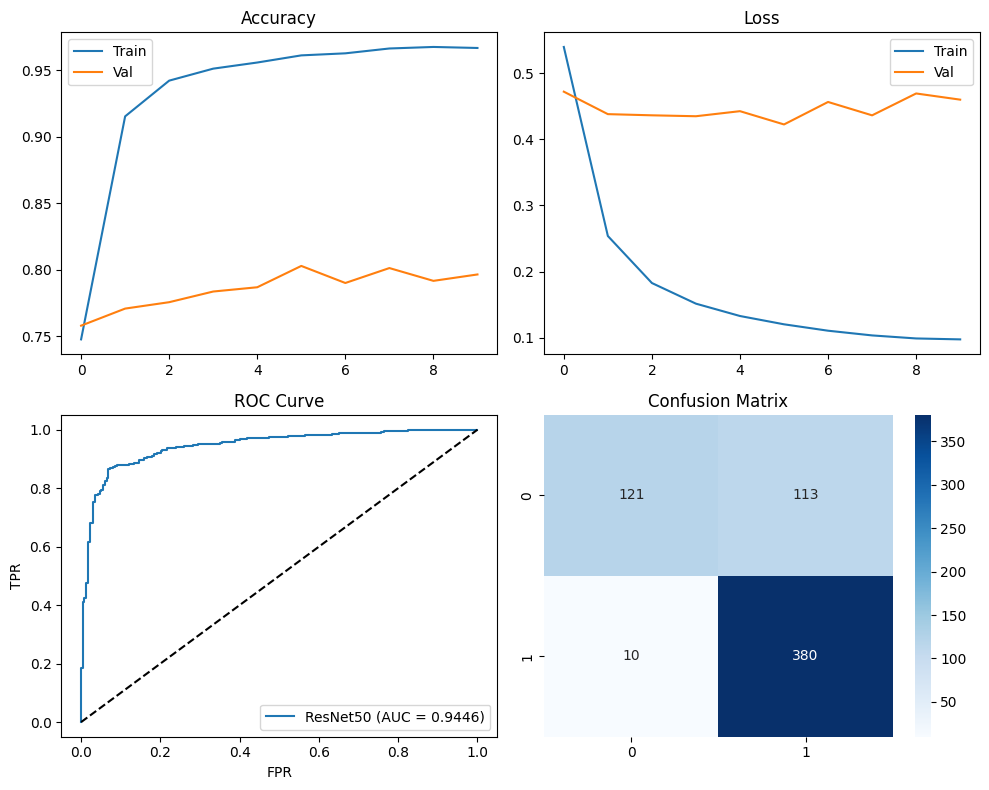

Classification Report:
               precision    recall  f1-score   support

           0     0.9237    0.5171    0.6630       234
           1     0.7708    0.9744    0.8607       390

    accuracy                         0.8029       624
   macro avg     0.8472    0.7457    0.7619       624
weighted avg     0.8281    0.8029    0.7866       624



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
train_dir = "/kaggle/input/chestxraydataset/chest_xray/train"
test_dir = "/kaggle/input/chestxraydataset/chest_xray/test"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 64
MODEL_SAVE_PATH = "chest_xray_resnet50_model.keras"

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_gen = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

# Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks: Adaptive LR + Early Stop
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

# Train
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    callbacks=[reduce_lr, early_stop]
)

# Save model
model.save(MODEL_SAVE_PATH)

# ========== Evaluation ========== #

# Accuracy and Loss
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

# ROC Curve
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen).ravel()
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
auc_score = roc_auc_score(y_true, y_pred_prob)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, label=f'ResNet50 (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')

# Confusion Matrix
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 604ms/step - accuracy: 0.7682 - loss: 0.4805 - val_accuracy: 0.7740 - val_loss: 0.4347 - learning_rate: 1.0000e-04
Epoch 2/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.9142 - loss: 0.2350 - val_accuracy: 0.7949 - val_loss: 0.4064 - learning_rate: 1.0000e-04
Epoch 3/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 576ms/step - accuracy: 0.9294 - loss: 0.1934 - val_accuracy: 0.8157 - val_loss: 0.3849 - learning_rate: 1.0000e-04
Epoch 4/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.9425 - loss: 0.1669 - val_accuracy: 0.7965 - val_loss: 0.4194 - learning_rate: 1.0000e-04
Epoch 5/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 574ms/step - accuracy: 0.9450 - loss: 0.1505 - val_accuracy: 0.8301 - val_loss: 0.3704 - learning_rate: 1.0000e-04
Epoch 6/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 570ms/step - accuracy: 0.9532 - loss: 0.1356 - val_accuracy: 0.8462 - val_loss: 0.3402 - learning_rate: 1.0000e-04
Epoch 7/64
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 5

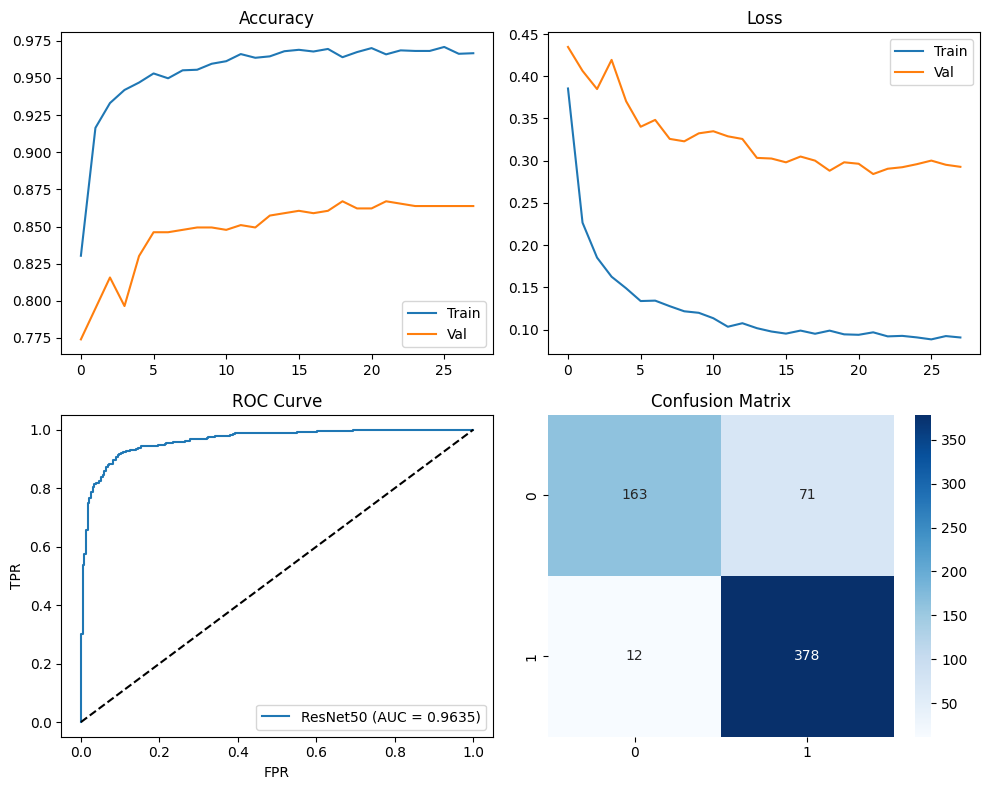

Classification Report:
               precision    recall  f1-score   support

           0     0.9314    0.6966    0.7971       234
           1     0.8419    0.9692    0.9011       390

    accuracy                         0.8670       624
   macro avg     0.8866    0.8329    0.8491       624
weighted avg     0.8755    0.8670    0.8621       624



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
train_dir = "/kaggle/input/chestxraydataset/chest_xray/train"
test_dir = "/kaggle/input/chestxraydataset/chest_xray/test"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 64
MODEL_SAVE_PATH = "chest_xray_resnet50_model.keras"

# Data Generators with Augmentation for Training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=10,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
#    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary', 
    shuffle=False
)

# Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# Train
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    callbacks=[reduce_lr, early_stop]
)

# Save model
model.save(MODEL_SAVE_PATH)

# ========== Evaluation ========== #

# Accuracy and Loss Curves
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

# ROC Curve
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen).ravel()
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
auc_score = roc_auc_score(y_true, y_pred_prob)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, label=f'ResNet50 (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')

# Confusion Matrix
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_177']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_177']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


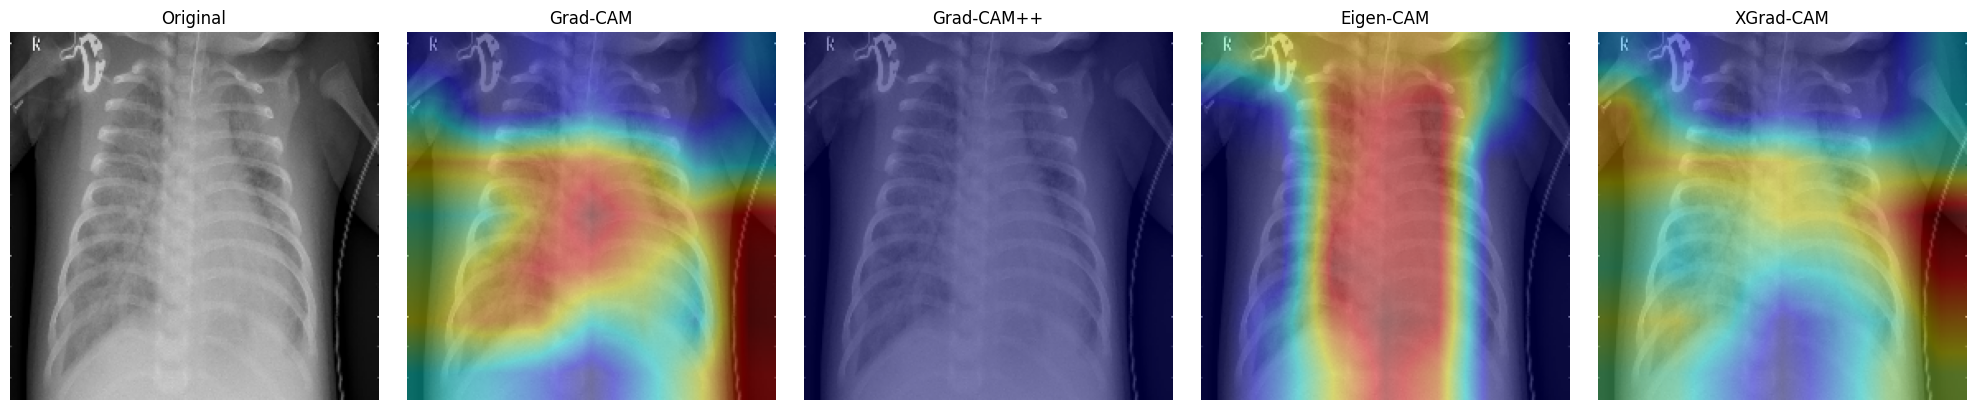

In [3]:
#part 2 Gradcam
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

# Constants
IMG_SIZE = (224, 224)

# Load and preprocess image
def get_img_array(img_path, size=IMG_SIZE):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    arr = tf.keras.preprocessing.image.img_to_array(img)
    return np.expand_dims(arr, axis=0)

# Grad-CAM
def grad_cam(img_array, model, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_output[0], axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# Grad-CAM++
def grad_cam_plus_plus(img_array, model, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape(persistent=True) as tape1:
        with tf.GradientTape() as tape2:
            conv_output, predictions = grad_model(img_array)
            class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]
        grads = tape2.gradient(loss, conv_output)
    second_grads = tape1.gradient(grads, conv_output)
    weights = tf.reduce_sum(grads * second_grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(weights * conv_output[0], axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# Eigen-CAM (PCA of feature maps)
def eigen_cam(img_array, model, layer_name):
    feature_model = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
    feature_maps = feature_model(img_array)[0].numpy()  # shape: (H, W, C)
    reshaped = feature_maps.reshape(-1, feature_maps.shape[-1])  # shape: (H*W, C)
    mean_centered = reshaped - reshaped.mean(axis=0)
    cov = np.cov(mean_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal_component = eigvecs[:, -1]  # use the top eigenvector
    projection = np.dot(mean_centered, principal_component)
    heatmap = projection.reshape(feature_maps.shape[:2])
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-10
    return heatmap

# XGrad-CAM
def x_grad_cam(img_array, model, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        score = predictions[:, class_idx]
    grads = tape.gradient(score, conv_output)[0]           # ∂y/∂A
    activation = conv_output[0]                             # A
    weights = tf.reduce_sum(grads * activation, axis=(0, 1))  # sum over spatial
    heatmap = tf.reduce_sum(weights * activation, axis=-1)    # weighted activation sum
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# Overlay heatmap
def overlay(heatmap, image):
    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

# Input image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img_array = tf.keras.applications.resnet50.preprocess_input(get_img_array(img_path))

# Compute CAMs
gradcam = grad_cam(img_array, model, "conv5_block3_out")
gradcam_pp = grad_cam_plus_plus(img_array, model, "conv5_block3_out")
eigen_cam_map = eigen_cam(img_array, model, "conv5_block3_out")
xgradcam = x_grad_cam(img_array, model, "conv5_block3_out")

# Load original image
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, IMG_SIZE)

# Create visualizations
gradcam_img = overlay(gradcam, original_img)
gradcampp_img = overlay(gradcam_pp, original_img)
eigen_img = overlay(eigen_cam_map, original_img)
xgrad_img = overlay(xgradcam, original_img)

# Display
titles = ["Original", "Grad-CAM", "Grad-CAM++", "Eigen-CAM", "XGrad-CAM"]
images = [original_img, gradcam_img, gradcampp_img, eigen_img, xgrad_img]

plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i][..., ::-1])  # BGR to RGB
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.04s/it]               


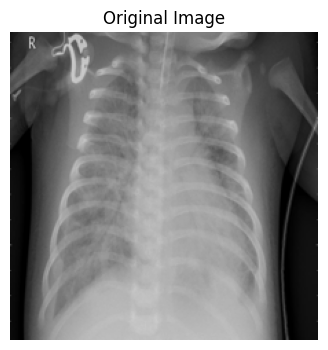

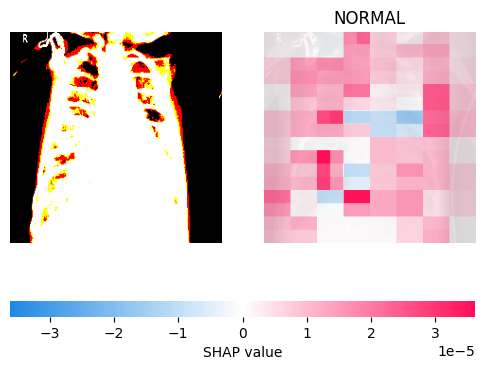

In [4]:
# Part 3 SHAP (Updated to show only original image and SHAP output)

import shap
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# 1. Load and preprocess image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_array_orig = np.array(img).astype(np.uint8)  # for displaying original image
img_array = np.array(img).astype(np.float32)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)

# 2. Define prediction function using your trained model
def f(x):
    return model(x).numpy()

# 3. Create SHAP masker and explainer
masker = shap.maskers.Image("inpaint_telea", img_array[0].shape)
explainer = shap.Explainer(f, masker, output_names=["NORMAL", "PNEUMONIA"])

# 4. Run SHAP and plot
shap_values = explainer(img_array, max_evals=300, batch_size=1, outputs=shap.Explanation.argsort.flip[:2])

# Show original image
plt.figure(figsize=(4, 4))
plt.imshow(img_array_orig)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Show SHAP explanation
shap.image_plot(shap_values)


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.68s/it]               


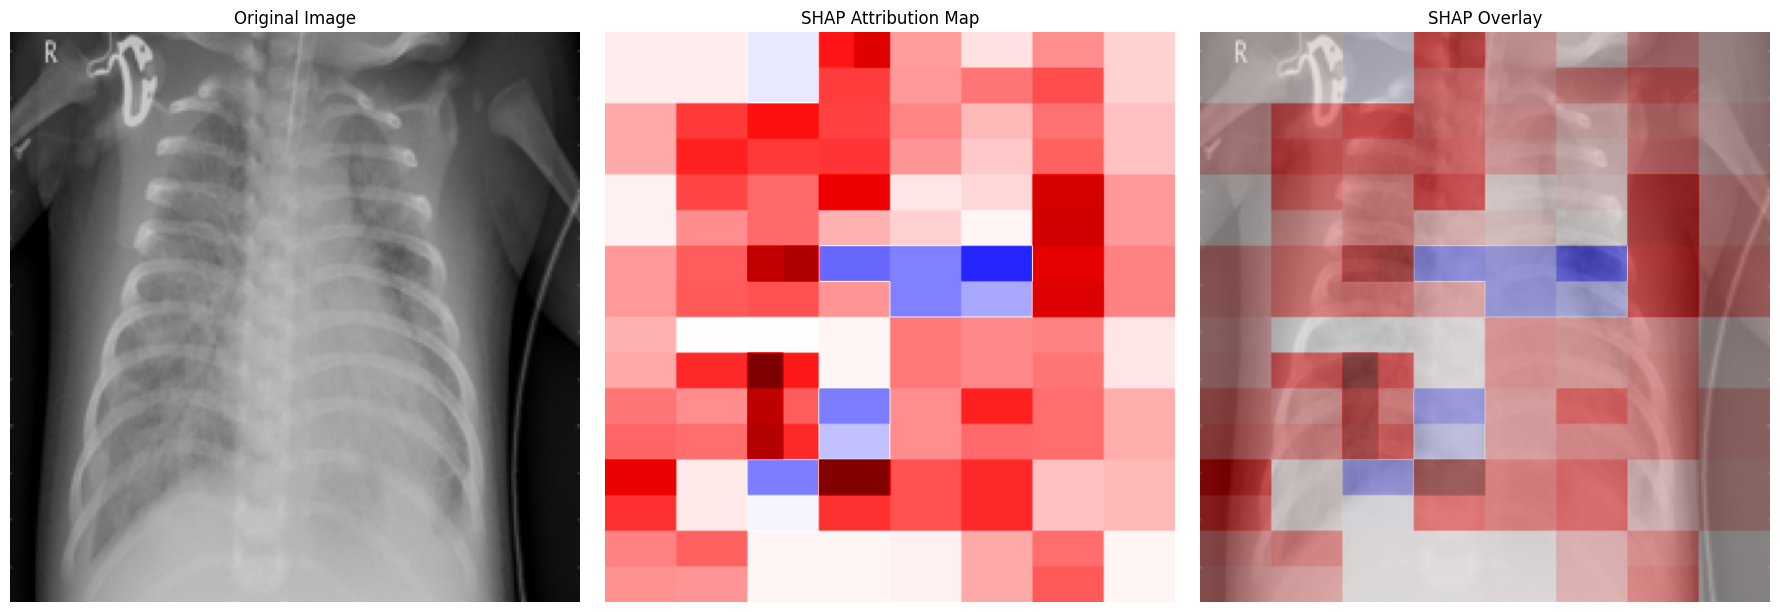

In [5]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# Load and preprocess image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_array_orig = np.array(img).astype(np.uint8)
img_array = tf.keras.applications.resnet50.preprocess_input(np.array(img).astype(np.float32))
img_array = np.expand_dims(img_array, axis=0)

# Define prediction function
def f(x):
    return model(x).numpy()

# SHAP explainer setup
masker = shap.maskers.Image("inpaint_telea", img_array[0].shape)
explainer = shap.Explainer(f, masker, output_names=["NORMAL", "PNEUMONIA"])

# Run SHAP
shap_values = explainer(img_array, max_evals=300, batch_size=1, outputs=shap.Explanation.argsort.flip[:2])

# Get SHAP values and reduce across channels to get 2D heatmap
shap_img = shap_values[0].values  # shape: (224, 224, 3)
shap_img_2d = shap_img.mean(axis=2)  # average across RGB channels → (224, 224)

# Normalize SHAP values to [-1, 1] for colormap
max_val = np.abs(shap_img_2d).max()
if max_val == 0:
    max_val = 1e-6
shap_img_norm = shap_img_2d / max_val

# Plot original, SHAP heatmap, and overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(img_array_orig)
axes[0].set_title("Original Image")
axes[0].axis('off')

# SHAP heatmap (red-blue)
axes[1].imshow(shap_img_norm, cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title("SHAP Attribution Map")
axes[1].axis('off')

# Overlay heatmap on original
overlay = img_array_orig.astype(np.float32) / 255.0
axes[2].imshow(overlay)
axes[2].imshow(shap_img_norm, cmap='seismic', alpha=0.5, vmin=-1, vmax=1)
axes[2].set_title("SHAP Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.show()


  0%|          | 0/2498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [06:06, 366.50s/it]              


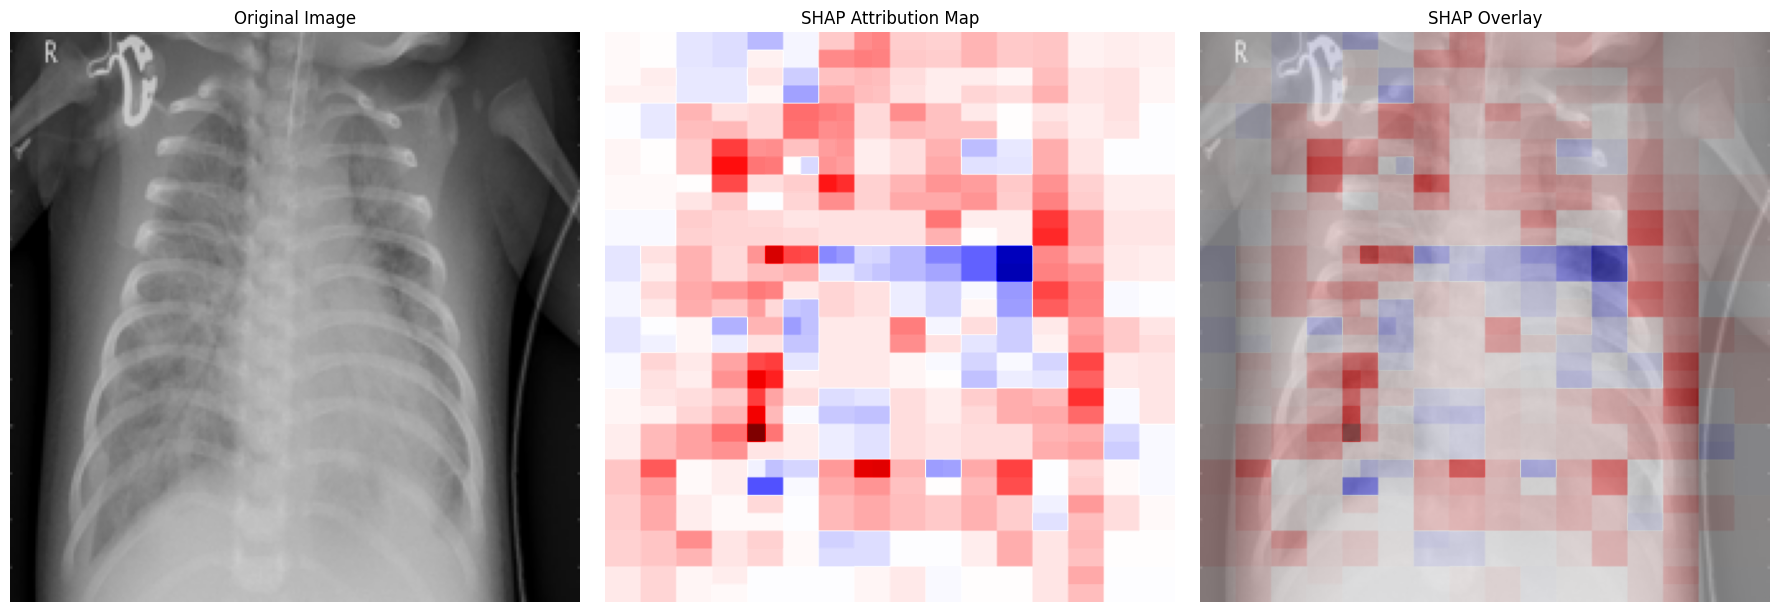

In [6]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# Load and preprocess image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_array_orig = np.array(img).astype(np.uint8)
img_array = tf.keras.applications.resnet50.preprocess_input(np.array(img).astype(np.float32))
img_array = np.expand_dims(img_array, axis=0)

# Define prediction function
def f(x):
    return model(x).numpy()

# SHAP masker
masker = shap.maskers.Image("inpaint_telea", img_array[0].shape)

# Create explainer (no output_names for binary classification)
explainer = shap.Explainer(f, masker)

# Run SHAP (no outputs=... for binary classification)
shap_values = explainer(
    img_array,
    max_evals=2500, #500
    batch_size=1
)

# Extract SHAP values and compute 2D heatmap
shap_img = shap_values[0].values  # shape: (224, 224, 3)
shap_img_2d = shap_img.mean(axis=2)  # (224, 224)

# Normalize
max_val = np.abs(shap_img_2d).max()
shap_img_norm = shap_img_2d / (max_val if max_val != 0 else 1e-6)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_array_orig)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(shap_img_norm, cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title("SHAP Attribution Map")
axes[1].axis('off')

overlay = img_array_orig.astype(np.float32) / 255.0
axes[2].imshow(overlay)
axes[2].imshow(shap_img_norm, cmap='seismic', alpha=0.5, vmin=-1, vmax=1)
axes[2].set_title("SHAP Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.show()


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:26, 146.22s/it]              
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


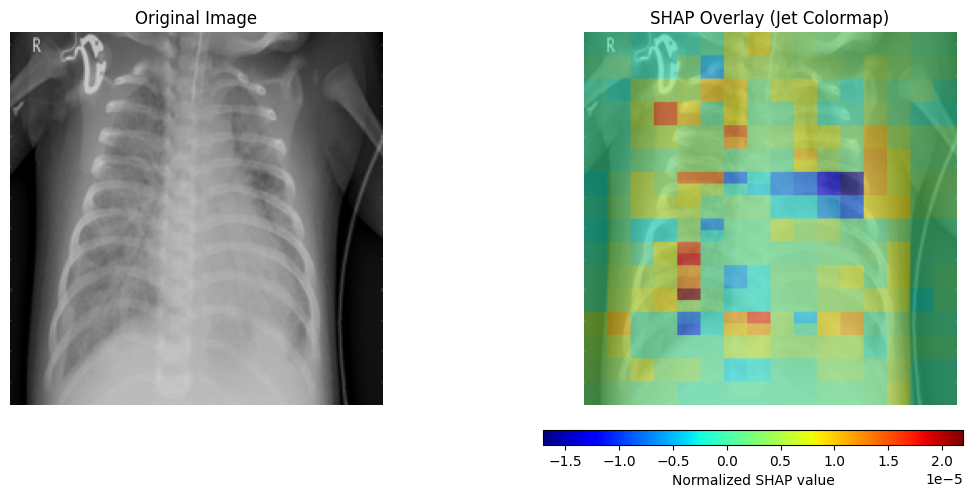

In [7]:
import shap
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# 1. Load and preprocess image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_array_orig = np.array(img).astype(np.uint8)  # For display
img_array = np.array(img).astype(np.float32)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# 2. Define prediction function
def f(x):
    return model(x).numpy()

# 3. Create SHAP explainer
masker = shap.maskers.Image("inpaint_telea", img_array[0].shape)
explainer = shap.Explainer(f, masker, output_names=["NORMAL", "PNEUMONIA"])

# 4. Run SHAP
shap_values = explainer(img_array, max_evals=1000, batch_size=1)
shap_val = shap_values.values[0]  # SHAP for class 0 (NORMAL), shape (224,224,3,1)

# 5. Fix shape: squeeze last dim if exists
if shap_val.shape[-1] == 1:
    shap_val = shap_val.squeeze(-1)  # Now (224, 224, 3)

# 6. Convert to grayscale
shap_gray = np.mean(shap_val, axis=-1)  # Shape becomes (224, 224)

# 7. Normalize SHAP values to [0,1]
shap_norm = (shap_gray - shap_gray.min()) / (shap_gray.max() - shap_gray.min() + 1e-8)

# 8. Apply colormap
heatmap = plt.cm.jet(shap_norm)[:, :, :3]  # Shape: (224, 224, 3)

# 9. Blend with original image
alpha = 0.5
overlay = (1 - alpha) * (img_array_orig / 255.0) + alpha * heatmap

# 10. Plot with color bar
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original image
ax[0].imshow(img_array_orig)
ax[0].set_title("Original Image")
ax[0].axis("off")

# SHAP Overlay with colorbar
im = ax[1].imshow(overlay)
ax[1].set_title("SHAP Overlay (Jet Colormap)")
ax[1].axis("off")

# Add color bar below the SHAP overlay
cbar_ax = fig.add_axes([0.55, 0.1, 0.35, 0.03])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=shap_gray.min(), vmax=shap_gray.max())
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='jet'), cax=cbar_ax, orientation='horizontal')
cbar.set_label('Normalized SHAP value')

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

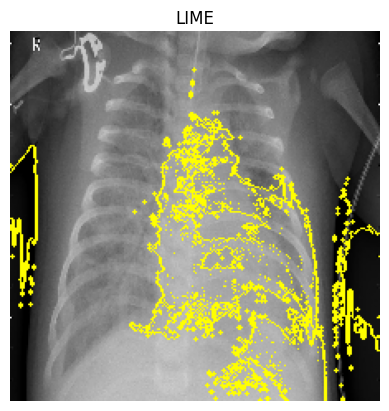

In [8]:
#Part 4 LIme
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=get_img_array(img_path)[0].astype('double'),
    classifier_fn=lambda x: model.predict(x, verbose=0),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME")
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

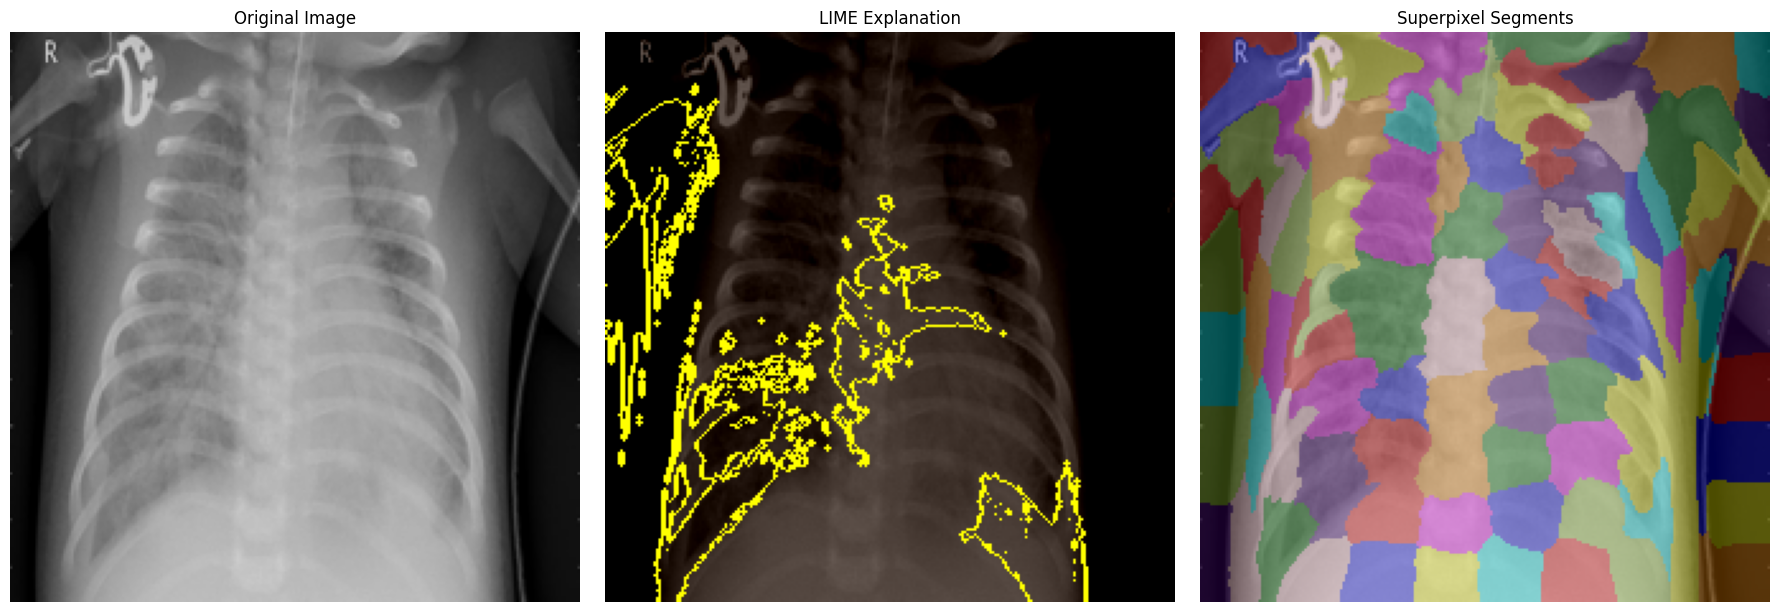

In [9]:
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
from skimage.color import label2rgb
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import logging
import warnings

# Suppress TensorFlow logging and NumPy warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 1. Load original image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_np = np.array(img)  # (224, 224, 3)

# 2. Preprocess function for model
def get_img_array(img_path):
    img = Image.open(img_path).resize((224, 224)).convert('RGB')
    x = np.array(img).astype(np.float32)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return np.expand_dims(x, axis=0)

# 3. LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=get_img_array(img_path)[0].astype('double'),
    classifier_fn=lambda x: model.predict(x, verbose=0),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# 4. Get LIME explanation and mask
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

lime_explained = mark_boundaries(temp / 255.0, mask)

# 5. Segment image for visualization
with np.errstate(divide='ignore', invalid='ignore'):
    segments = slic(img_np, n_segments=100, compactness=10, sigma=1)
    segmented_image = label2rgb(segments, img_np, kind='overlay')

# 6. Display original, LIME, and segmented images
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img_np)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(lime_explained)
axs[1].set_title("LIME Explanation")
axs[1].axis('off')

axs[2].imshow(segmented_image)
axs[2].set_title("Superpixel Segments")
axs[2].axis('off')

plt.tight_layout()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

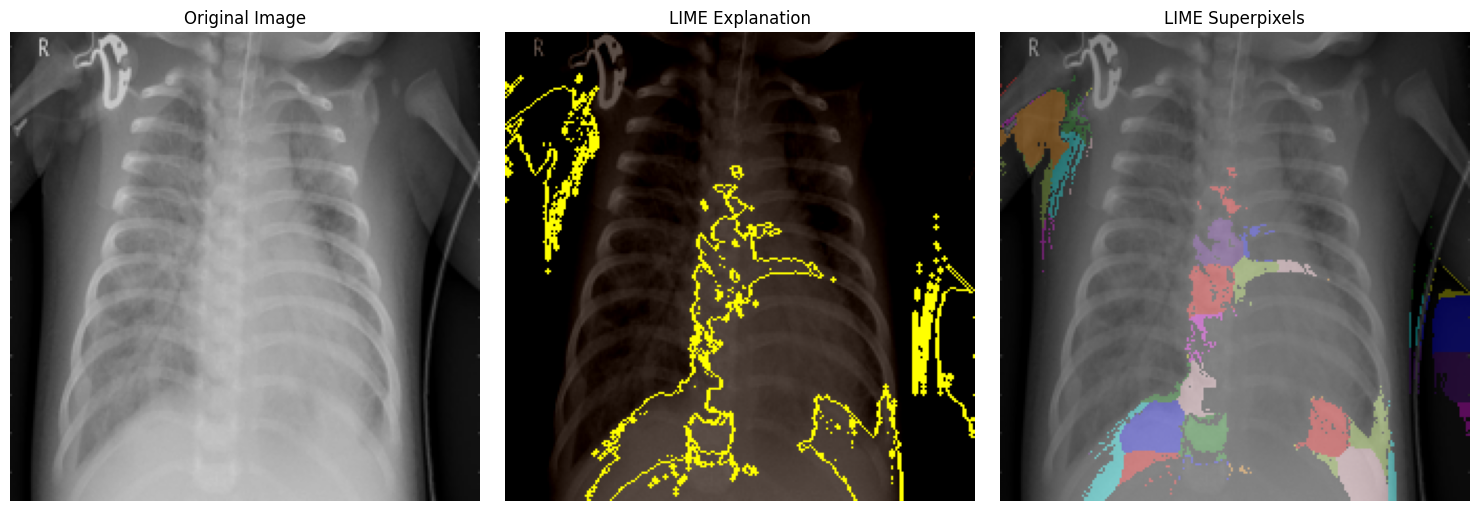

In [10]:
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
from skimage.color import label2rgb
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import logging
import warnings

# Suppress TensorFlow and NumPy warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load and preprocess image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_np = np.array(img)

# Preprocessing for model
def get_img_array(img_path):
    img = Image.open(img_path).resize((224, 224)).convert('RGB')
    x = np.array(img).astype(np.float32)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return np.expand_dims(x, axis=0)

# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=get_img_array(img_path)[0].astype('double'),
    classifier_fn=lambda x: model.predict(x, verbose=0),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Extract LIME mask and image
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

lime_image_result = mark_boundaries(temp / 255.0, mask)

# Suppress divide-by-zero warnings during superpixel overlay
with np.errstate(divide='ignore', invalid='ignore'):
    segments = slic(img_np, n_segments=100, compactness=10, sigma=1)
    segmented_image = label2rgb(mask * segments, img_np, kind='overlay')

# Plot all three images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_np)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(lime_image_result)
axs[1].set_title("LIME Explanation")
axs[1].axis('off')

axs[2].imshow(segmented_image)
axs[2].set_title("LIME Superpixels")
axs[2].axis('off')

plt.tight_layout()
plt.show()


  0%|          | 0/2000 [00:00<?, ?it/s]

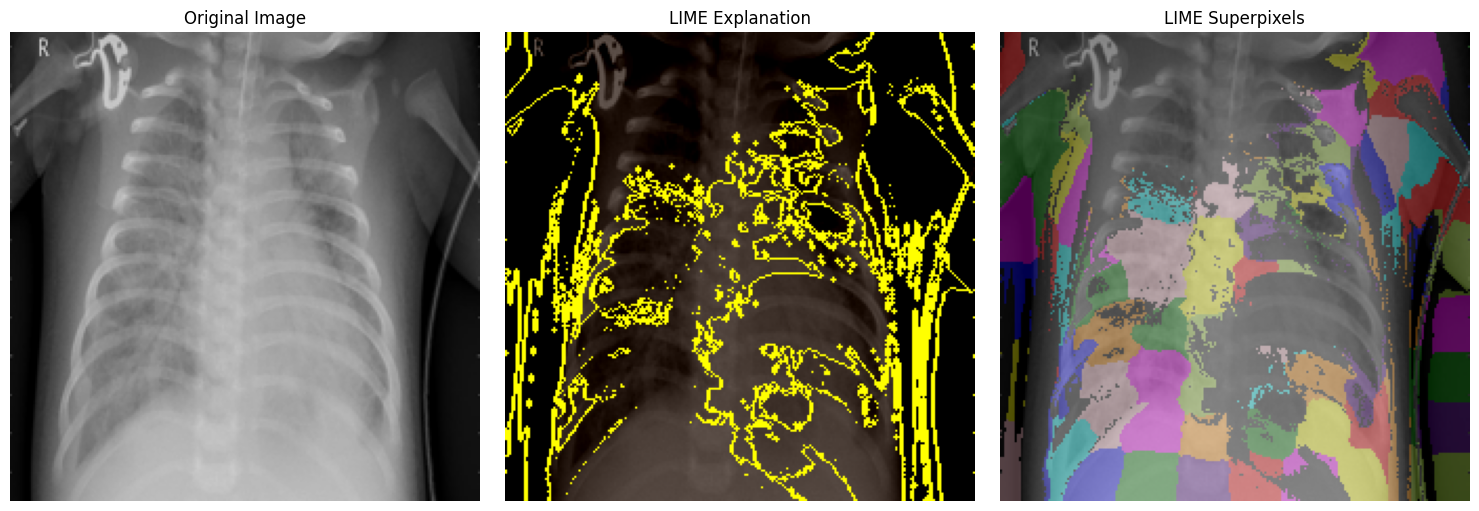

In [11]:
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
from skimage.color import label2rgb
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import logging
import warnings

# Suppress TensorFlow and NumPy warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Load and preprocess image
img_path = "/kaggle/input/chestxraydataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
img = Image.open(img_path).resize((224, 224)).convert('RGB')
img_np = np.array(img)

# Preprocessing for model
def get_img_array(img_path):
    img = Image.open(img_path).resize((224, 224)).convert('RGB')
    x = np.array(img).astype(np.float32)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return np.expand_dims(x, axis=0)

# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=get_img_array(img_path)[0].astype('double'),
    classifier_fn=lambda x: model.predict(x, verbose=0),
    top_labels=1,
    hide_color=0,
    num_samples=2000
)

# Extract LIME mask and image
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=25,
    hide_rest=False
)

lime_image_result = mark_boundaries(temp / 255.0, mask)

# Suppress divide-by-zero warnings during superpixel overlay
with np.errstate(divide='ignore', invalid='ignore'):
    segments = slic(img_np, n_segments=100, compactness=10, sigma=1)
    segmented_image = label2rgb(mask * segments, img_np, kind='overlay')

# Plot all three images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_np)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(lime_image_result)
axs[1].set_title("LIME Explanation")
axs[1].axis('off')

axs[2].imshow(segmented_image)
axs[2].set_title("LIME Superpixels")
axs[2].axis('off')

plt.tight_layout()
plt.show()
